In [13]:
# Import all the libraries
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import haversine_distances
import warnings
warnings.filterwarnings('ignore')

In [14]:

def load_data_1_coordinates():
    """
    Load all GPS coordinates from Data_1 files (Bridge, RailJoint, Turnout)
    """
    data_1_path = Path("Data_1")
    coordinates = []
    
    # Files to process
    files = [
        "converted_coordinates_Resultat_Bridge.csv",
        "converted_coordinates_Resultat_RailJoint.csv", 
        "converted_coordinates_Turnout.csv"
    ]
    
    for file in files:
        file_path = data_1_path / file
        if file_path.exists():
            try:
                df = pd.read_csv(file_path)
                # Extract latitude and longitude
                if 'Latitude' in df.columns and 'Longitude' in df.columns:
                    coords = df[['Latitude', 'Longitude']].dropna()
                    coordinates.extend(coords.values.tolist())
                    print(f"Loaded {len(coords)} coordinates from {file}")
                else:
                    print(f"Warning: {file} doesn't have Latitude/Longitude columns")
            except Exception as e:
                print(f"Error loading {file}: {e}")
    
    return np.array(coordinates)

def load_data_2_coordinates(folder_path):
    """
    Load GPS coordinates from a Data_2 folder
    """
    try:
        lat_file = folder_path / "GPS.latitude.csv"
        lon_file = folder_path / "GPS.longitude.csv"
        
        if not lat_file.exists() or not lon_file.exists():
            return None
        
        # Read latitude and longitude files
        latitudes = pd.read_csv(lat_file, header=None).values.flatten()
        longitudes = pd.read_csv(lon_file, header=None).values.flatten()
        
        # Combine into coordinate pairs
        coordinates = np.column_stack((latitudes, longitudes))
        
        # Remove any invalid coordinates (NaN values)
        valid_mask = ~(np.isnan(coordinates).any(axis=1))
        coordinates = coordinates[valid_mask]
        
        return coordinates
    
    except Exception as e:
        print(f"Error loading coordinates from {folder_path}: {e}")
        return None

def calculate_coordinate_overlap(coords1, coords2, threshold_km=1.0):
    """
    Calculate overlap between two sets of coordinates
    Returns: overlap percentage and distance metrics
    """
    if len(coords1) == 0 or len(coords2) == 0:
        return 0.0, float('inf')
    
    # Calculate distances between all points
    # Convert to radians for haversine calculation
    coords1_rad = np.radians(coords1)
    coords2_rad = np.radians(coords2)
    
    # Calculate haversine distances
    distances = haversine_distances(coords1_rad, coords2_rad) * 6371  # Convert to km
    
    # Find minimum distance for each point in coords1 to any point in coords2
    min_distances = np.min(distances, axis=1)
    
    # Count points within threshold
    points_within_threshold = np.sum(min_distances <= threshold_km)
    overlap_percentage = (points_within_threshold / len(coords1)) * 100
    
    # Calculate average minimum distance
    avg_min_distance = np.mean(min_distances)
    
    return overlap_percentage, avg_min_distance

def find_matching_track():
    """
    Find the Data_2 folder that contains the same track as Data_1
    """
    print("Loading Data_1 coordinates...")
    data_1_coords = load_data_1_coordinates()
    
    if len(data_1_coords) == 0:
        print("No coordinates found in Data_1!")
        return None
    
    print(f"Loaded {len(data_1_coords)} coordinates from Data_1")
    print(f"Data_1 coordinate range:")
    print(f"  Latitude: {data_1_coords[:, 0].min():.6f} to {data_1_coords[:, 0].max():.6f}")
    print(f"  Longitude: {data_1_coords[:, 1].min():.6f} to {data_1_coords[:, 1].max():.6f}")
    
    # Get all Data_2 folders
    data_2_path = Path("Data_2")
    if not data_2_path.exists():
        print("Data_2 directory not found!")
        return None
    
    # Find all subdirectories in Data_2
    data_2_folders = []
    for item in data_2_path.iterdir():
        if item.is_dir():
            # Check if it contains GPS files
            if (item / "GPS.latitude.csv").exists() and (item / "GPS.longitude.csv").exists():
                data_2_folders.append(item)
    
    print(f"\nFound {len(data_2_folders)} folders in Data_2 with GPS data")
    
    # Compare each folder
    results = []
    
    for folder in data_2_folders:
        print(f"\nProcessing {folder.name}...")
        
        data_2_coords = load_data_2_coordinates(folder)
        if data_2_coords is None or len(data_2_coords) == 0:
            continue
        
        print(f"  Loaded {len(data_2_coords)} coordinates")
        print(f"  Coordinate range:")
        print(f"    Latitude: {data_2_coords[:, 0].min():.6f} to {data_2_coords[:, 0].max():.6f}")
        print(f"    Longitude: {data_2_coords[:, 1].min():.6f} to {data_2_coords[:, 1].max():.6f}")
        
        # Calculate overlap
        overlap_percentage, avg_distance = calculate_coordinate_overlap(data_1_coords, data_2_coords)
        
        results.append({
            'folder': folder.name,
            'folder_path': str(folder),
            'num_coordinates': len(data_2_coords),
            'overlap_percentage': overlap_percentage,
            'avg_distance_km': avg_distance,
            'lat_range': (data_2_coords[:, 0].min(), data_2_coords[:, 0].max()),
            'lon_range': (data_2_coords[:, 1].min(), data_2_coords[:, 1].max())
        })
        
        print(f"  Overlap: {overlap_percentage:.2f}%")
        print(f"  Average distance: {avg_distance:.2f} km")
    
    # Sort results by overlap percentage (descending)
    results.sort(key=lambda x: x['overlap_percentage'], reverse=True)
    
    # Display results
    print("\n" + "="*80)
    print("MATCHING RESULTS (sorted by overlap percentage)")
    print("="*80)
    
    for i, result in enumerate(results[:10]):  # Show top 10
        print(f"\n{i+1}. {result['folder']}")
        print(f"   Overlap: {result['overlap_percentage']:.2f}%")
        print(f"   Average distance: {result['avg_distance_km']:.2f} km")
        print(f"   Coordinates: {result['num_coordinates']}")
        print(f"   Lat range: {result['lat_range'][0]:.6f} to {result['lat_range'][1]:.6f}")
        print(f"   Lon range: {result['lon_range'][0]:.6f} to {result['lon_range'][1]:.6f}")
    
    # Return the best match
    if results:
        best_match = results[0]
        print(f"\n BEST MATCH: {best_match['folder']}")
        print(f"   Overlap: {best_match['overlap_percentage']:.2f}%")
        print(f"   Path: {best_match['folder_path']}")
        return best_match
    else:
        print("\n No matching tracks found!")
        return None

def visualize_comparison(data_1_coords, data_2_coords, folder_name):
    """
    Create a visualization comparing Data_1 and Data_2 coordinates
    """
    plt.figure(figsize=(15, 10))
    
    # Plot Data_1 coordinates
    plt.subplot(1, 2, 1)
    plt.scatter(data_1_coords[:, 1], data_1_coords[:, 0], c='red', s=20, alpha=0.7, label='Data_1 (Bridge/Joint/Turnout)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Data_1 Coordinates')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot Data_2 coordinates
    plt.subplot(1, 2, 2)
    plt.scatter(data_2_coords[:, 1], data_2_coords[:, 0], c='blue', s=1, alpha=0.5, label='Data_2 (Track)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Data_2 Coordinates: {folder_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'track_comparison_{folder_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

Loading Data_1 coordinates...
Loaded 25 coordinates from converted_coordinates_Resultat_Bridge.csv
Loaded 20 coordinates from converted_coordinates_Resultat_RailJoint.csv
Loaded 75 coordinates from converted_coordinates_Turnout.csv
Loaded 120 coordinates from Data_1
Data_1 coordinate range:
  Latitude: 60.510878 to 61.009065
  Longitude: 14.518605 to 15.352741

Found 124 folders in Data_2 with GPS data

Processing 2024-12-25 07-13-44 (1)...
  Loaded 13880 coordinates
  Coordinate range:
    Latitude: 0.000000 to 60.482610
    Longitude: 0.000000 to 15.424527
  Overlap: 0.00%
  Average distance: 44.35 km

Processing 2024-12-22 14-37-21 (1)...
Error loading coordinates from Data_2/2024-12-22 14-37-21 (1): No columns to parse from file

Processing 2024-12-25 18-00-00 (1)...
Error loading coordinates from Data_2/2024-12-25 18-00-00 (1): No columns to parse from file

Processing 2024-12-17 02-00-00 (1)...
  Loaded 36001 coordinates
  Coordinate range:
    Latitude: 60.667166 to 60.672834
  

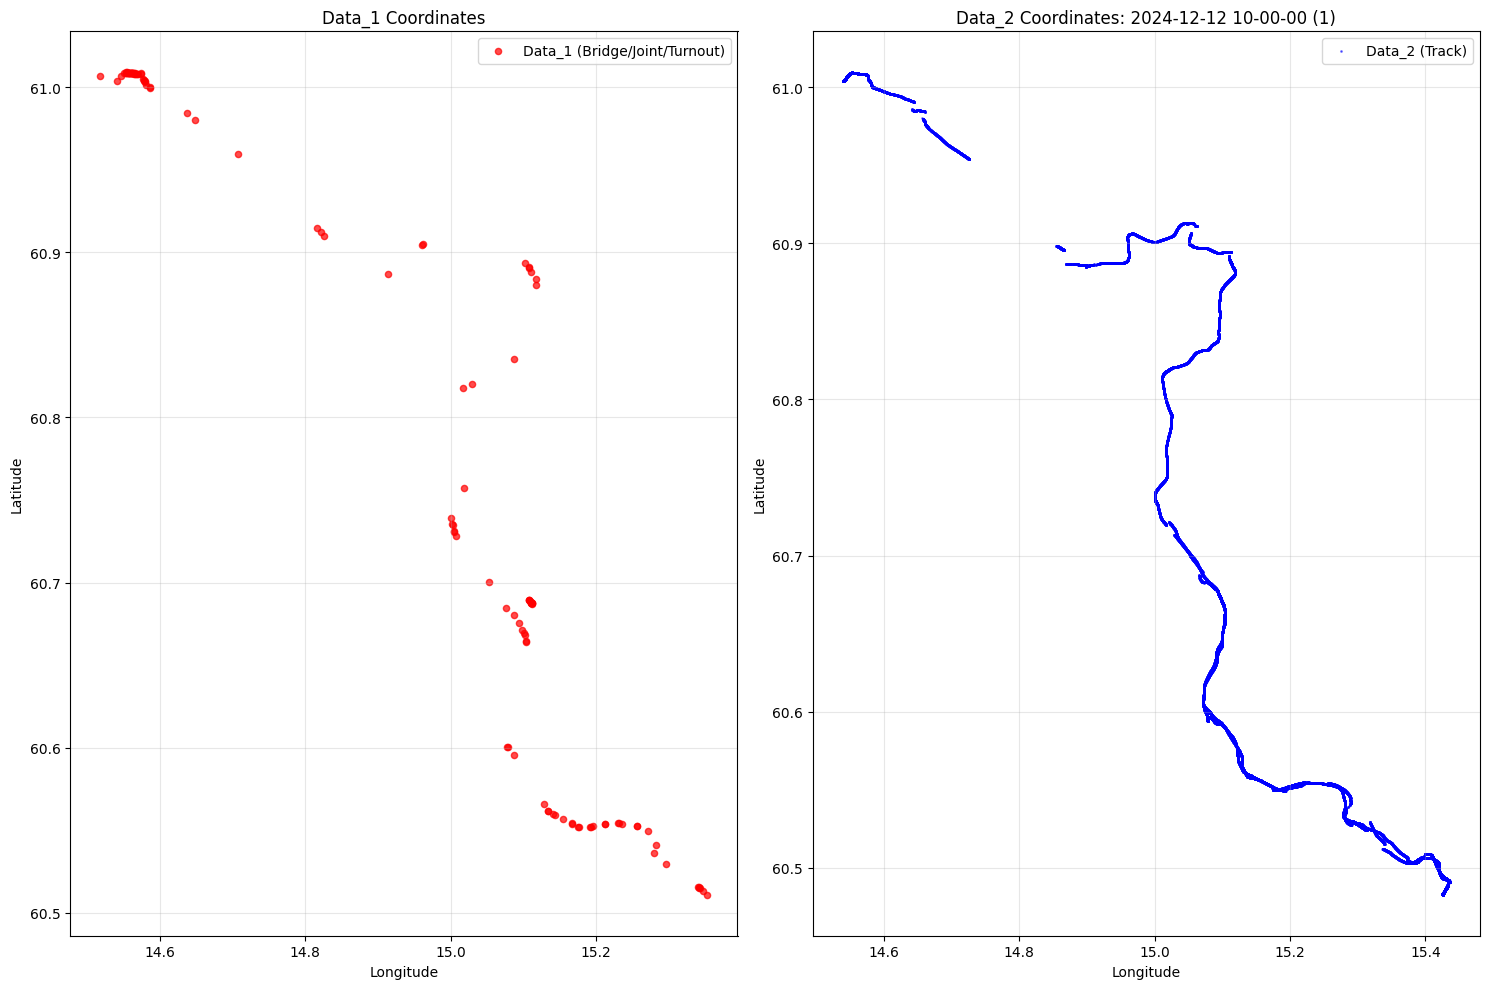

In [15]:
# Find the matching track
best_match = find_matching_track()

if best_match:
    print(f"\n Found matching track: {best_match['folder']}")
    print(f" Path: {best_match['folder_path']}")
    
    # Optional: Create visualization
    data_1_coords = load_data_1_coordinates()
    data_2_coords = load_data_2_coordinates(Path(best_match['folder_path']))
    
    if data_1_coords is not None and data_2_coords is not None:
        visualize_comparison(data_1_coords, data_2_coords, best_match['folder'])
else:
    print("\n No matching track found!")